# Collapsing Orthologous Nodes

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt/)

Often, knowledge about the molecular interactions within one species can be used to make inferences about other species. This notebook outlines how human and rat genes can be mapped to their orthologous mouse genes in a BEL network produced by `PyBEL`.

In [1]:
import os
import time
from collections import defaultdict, Counter

import pybel
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pybel.get_version()

'PyBEL Version: 0.2.5'

In [3]:
time.asctime()

'Tue Nov 15 17:25:09 2016'

## Acquisition of Data

Gene orthology data is avaliable in BEL from OpenBEL. They take the form of `g(A) orthologous g(B)` where `A` and `B` correspond to identifiers for genes in different species-specific namespaces, such as HGNC, MGI, and RGD. 

In [4]:
gene_orthology_url = 'http://resources.openbel.org/belframework/20150611/resource/gene-orthology.bel'

In [5]:
# Download, parse, and cache if not already avaliable as a gpickle

path = os.path.expanduser('~/.pybel/gene-orthology.gpickle')

if not os.path.exists(path):
    orthology = pybel.from_url(gene_orthology_url)
    pybel.to_pickle(g, path)
else:
    orthology = pybel.from_pickle(path)

Protein family and namex protein complex orthology data is also avaliable from OpenBEL. In the 1.0 release, there were species-specific files defining the memberships of protein families and , and another defining the family orthology. As of the most recent release, the names of these complexes have been normalized, and the human, mouse, and rat members are annotated to the same complex.

In [6]:
named_complexes_url = 'http://resources.openbel.org/belframework/20150611/resource/named-complexes.bel'
protein_families_url = 'http://resources.openbel.org/belframework/20150611/resource/protein-families.bel'

## Construction of Equivalence Classes

In this example, the directed BEL graph is relaxed to be undirected and connected components are grouped to reflect transitive equivalence. A mapping from each node to its "equivalence" class is built, and then further a mapping from each "equivalence class" to its contained Mouse Genome Informatics (MGI) name. 

In [7]:
orthology_undirected = orthology.to_undirected()

In [8]:
index2component = {}
member2index = {}
index2mgi = {}

for i, component in enumerate(nx.connected_components(orthology_undirected)):
    index2component[i] = component

    for function, namespace, name in component:
        member2index[function, namespace, name] = i

        if 'MGI' == namespace:
            index2mgi[i] = function, namespace, name

In [9]:
mapping = {}

for function, namepace, name in orthology_undirected:
    if (function, namepace, name) not in member2index:
        continue
        
    index = member2index[function, namepace, name]
    
    if index not in index2mgi:
        continue
        
    mapping[function, namepace, name] = index2mgi[index]

## Application to a Sample Corpus

The Selventa Example Large Corpus is loaded. Below is shown the frequency of entities from each namespace used within the resulting graph.

In [10]:
g = pybel.get_large_corpus()

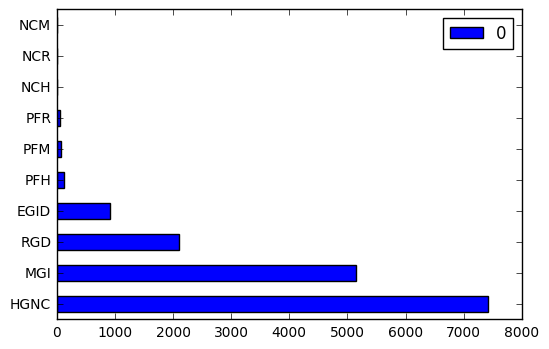

In [11]:
before_counter = Counter(node[1] for node in g.nodes_iter() if g.node[node]['type'] == 'Gene')

before_df = pd.DataFrame.from_dict(before_counter, orient='index')
before_df.sort_values(0, ascending=False).plot(kind='barh')
plt.show()

The entries from HGNC and RGD are mapped to MGI wherever possible, and the new namespace frequencies are shown.

In [12]:
# Map node data
for name, data in g.nodes_iter(data=True):
    if data['type'] in ('Gene','RNA','Protein') and name in mapping:
        g.node[name].update(orthology_undirected.node[mapping[name]])

In [13]:
# Map node labels
g_relabeled = nx.relabel_nodes(g, lambda n: mapping[n] if n in mapping else n, copy=False)

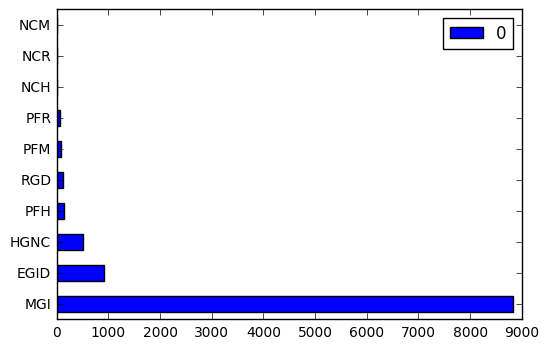

In [14]:
after_counter = Counter(node[1] for node in g_relabeled.nodes_iter() if g_relabeled.node[node]['type'] == 'Gene')

after_df = pd.DataFrame.from_dict(after_counter, orient='index')
after_df.sort_values(0, ascending=False).plot(kind='barh')
plt.show()

In [15]:
# cache the resulting graph as a gpickle for later
path = os.path.expanduser('~/.pybel/large_corpus_mgi.gpickle')
pybel.to_pickle(g_relabeled, path)

# Conclusions

The mapping of orthologous genes allows for inference to be made from translational research. BEL and PyBEL provide easy mechanisms for mapping from one type to another. While it's not possible to map all gene names with the OpenBEL orthology documents, further data can be acquired from HGNC with up-to-date equivalences.